In [10]:
import Pkg; Pkg.activate("../"); # Activate the project 
# Import all the necessary libraries
libraries = ["QuTaM", "LinearAlgebra", "Plots", "LaTeXStrings", "Statistics", "OrdinaryDiffEq", "ProgressMeter", "CSV", "DataFrames"]

function ensure_imports(packages::Vector{String})
    for pkg in packages
        try
            @eval using $(Symbol(pkg))
        catch e
            if e isa ArgumentError && occursin(pkg, e.msg)
                println("Installing $pkg...")
                Pkg.add(pkg)
                @eval using $(Symbol(pkg))
            else
                rethrow(e)
            end
        end
    end
end

ensure_imports(libraries)

  Activating project at `~/Documents/Research/MonitoringMetrology/QuTaM.jl`


In [33]:
function analytical_contribution(t, traj::Trajectory, gamma::Float64, n)
    if isempty(traj)
        return -n*t
    end
    jump_times = cumsum([click.time for click in traj])
    m = 0 # number of jumps
    # Find which was the last jump that occured
    for t_jump in jump_times
        if t_jump > t
            break
        end
        m = m +1
    end 
    if m == 0
        return -n*t
    end 
    #print(m)
    return m/gamma - sum(jump_times[1:m]) -(n-m)*t
  
end

analytical_contribution (generic function with 1 method)

# Qubit Trajectory Contribution

In [20]:
qubit_sys = QuTaM.rd_sys 
qubit_params = SimulParameters(QuTaM.rd_psi0,
    3.0, # Final time. Set very long so that all trajectories jump
    1, # seed
    1000, # Number of trajectories
    50_000, # Number of samples in the finegrid
    10.5, # Multiplier to use in the fine grid
    1e-3 # Tolerance for passing Dark state test
)
H_parametrized = (delta::Float64, gamma::Float64) -> (0.5*delta*QuTaM.sigma_z)::Matrix{ComplexF64}
L_parametrized = (delta::Float64, gamma::Float64) -> (sqrt(gamma)*QuTaM.sigma_m)::Matrix{ComplexF64}
Heff_parametrized = QuTaM.GetHeffParametrized(H_parametrized, [L_parametrized])

#11 (generic function with 1 method)

In [21]:
qubit_trajectories = run_trajectories(qubit_sys, qubit_params);

Sampling... 100%|██████████████████████████| Time: 0:00:07 ( 7.36 ms/it)


In [21]:
ntimes = 100
t_given = collect(LinRange(0, qubit_params.tf, ntimes));

In [23]:
qubit_xi_sample = Array{ComplexF64}(undef, qubit_sys.NLEVELS, qubit_sys.NLEVELS, ntimes, qubit_params.ntraj)
for n in 1:qubit_params.ntraj
    qubit_xi_sample[:, :, :, n] = MonitoringOperator(t_given, qubit_sys, Heff_parametrized, [L_parametrized], qubit_trajectories[n], qubit_params.psi0,
                           [QuTaM.rd_deltaomega, QuTaM.rd_gamma], [0.0, QuTaM.rd_gamma/100])
end 

In [24]:
qubit_xi_sample[:, :, end, 1]

2×2 Matrix{ComplexF64}:
 0.332703+0.0im  0.0+0.0im
      0.0-0.0im  0.0+0.0im

In [25]:
contribution_qubit_sample = Array{Float64}(undef, ntimes, qubit_params.ntraj)
for n in 1:qubit_params.ntraj
    for k in 1:ntimes
       contribution_qubit_sample[k, n] = real(tr(xi_sample[:, :, k, n]))
    end 
end 

In [26]:
f_analytical_qubit(t) = analytical_contribution(t, trajectories[10], QuTaM.rd_gamma, sys.NLEVELS-1)

f_analytical_qubit (generic function with 1 method)

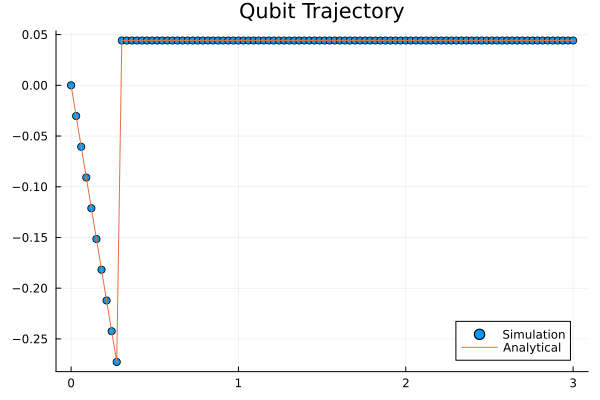

In [28]:
f_analytical_qubit(t) = analytical_contribution(t, qubit_trajectories[10], QuTaM.rd_gamma, 2-1)
scatter(t_given, contribution_qubit_sample[:, 10], label="Simulation", title="Qubit Trajectory")
plot!(t_given, f_analytical_qubit.(t_given), label="Analytical")

# N level system

In [28]:
# First things is to define this system 
# Construct the destruction operator
NLEVELS = 3
a = zeros(ComplexF64, NLEVELS, NLEVELS)
for k in 1:NLEVELS
    for m in 1:NLEVELS
        if k == m + 1
            a[m, k] = 1.0
        end 
    end 
end

EPS = 1e-5 # Tolerance for the distance respect to the Frobenious norm
GAMMA = QuTaM.rd_gamma

H = 0.5*QuTaM.rd_deltaomega*adjoint(a)*a
L = sqrt(GAMMA)*a
sys = System(H, [L]);

PSI0 = zeros(ComplexF64, NLEVELS)
PSI0[end] = 1 # Initial condition

params = SimulParameters(PSI0,
    3.0, # Final time. Set very long so that all trajectories jump
    1, # seed
    500, # Number of trajectories
    50_000, # Number of samples in the finegrid
    10.5, # Multiplier to use in the fine grid
    1e-3 # Tolerance for passing Dark state test
);
# Parametrization
H_parametrized = (delta::Float64, gamma::Float64) -> (0.5*delta*adjoint(a)*a)::Matrix{ComplexF64}
L_parametrized = (delta::Float64, gamma::Float64) -> (sqrt(gamma)*a)::Matrix{ComplexF64}
He_parametrized = QuTaM.GetHeffParametrized(H_parametrized, [L_parametrized])
trajectories = run_trajectories(sys, params);


Sampling... 100%|██████████████████████████| Time: 0:00:06 (12.46 ms/it)


In [31]:
xi_sample = Array{ComplexF64}(undef, sys.NLEVELS, sys.NLEVELS, ntimes, params.ntraj)
for n in 1:params.ntraj
    xi_sample[:, :, :, n] = MonitoringOperator(t_given, sys, He_parametrized, [L_parametrized], trajectories[n], params.psi0,
                           [QuTaM.rd_deltaomega, QuTaM.rd_gamma], [0.0, QuTaM.rd_gamma/100])
end 
contribution_sample = Array{Float64}(undef, ntimes, params.ntraj)
for k in 1:params.ntraj
    for tn in 1:ntimes
        contribution_sample[tn, k] = real(tr(xi_sample[:, :, tn, k]))       
    end 
end 

In [37]:
f_analytical(t) = analytical_contribution(t, trajectories[1], QuTaM.rd_gamma, sys.NLEVELS-1)

f_analytical (generic function with 1 method)

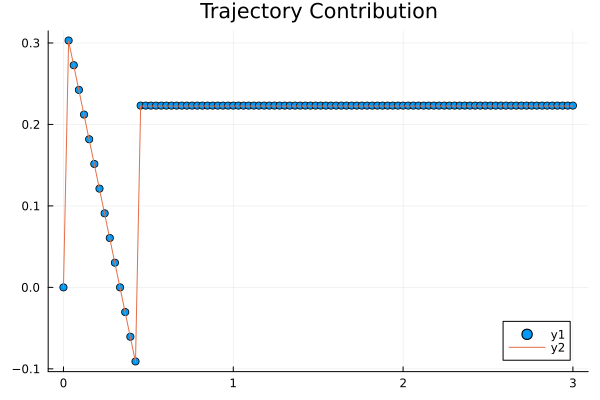

In [40]:
scatter(t_given, contribution_sample[:, 1])
plot!(t_given, f_analytical.(t_given), title="Trajectory Contribution")

In [30]:
xi_sample[:,:, end, 1]

3×3 Matrix{ComplexF64}:
 0.223138+0.0im  0.0-0.0im  0.0-0.0im
      0.0+0.0im  0.0+0.0im  0.0+0.0im
      0.0+0.0im  0.0+0.0im  0.0+0.0im